# **ICA Processing Framework**

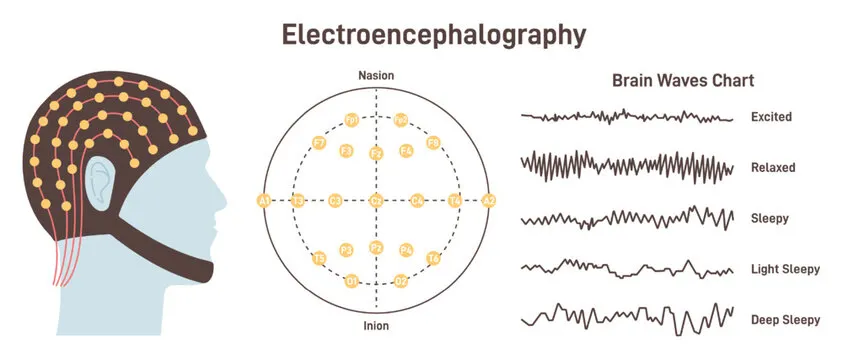

In [1]:
# Imports
import os
import re
from pathlib import Path
# Import all functions from the functional script
from auto_ica_functional import * 

# Configuration
BASE_BIMA = '/home/jaizor/jaizor/xtra/derivatives/eeg/crop/bima_off'
BASE_REST = '/home/jaizor/jaizor/xtra/derivatives/eeg/crop/rest_off'
GPS_FILE = '/home/jaizor/jaizor/xtra/data/ghw280_from_egig.gpsc'
OUTPUT_DIR = '/home/jaizor/jaizor/xtra/derivatives/eeg/ica'

def extract_task_from_filename(filename):
    """Extract task from filename like 'rest_off_sub-02_eyes_closed_eeg.fif'."""
    pattern = r'(?:bima_off|rest_off)_sub-\d+_(.*)_eeg\.fif'
    match = re.search(pattern, filename)
    return match.group(1) if match else None

def natural_sort_key(path):
    """Extract subject number for natural numeric sorting (e.g., sub-2 -> 2)."""
    name = path.name
    if name.startswith('sub-'):
        try:
            return int(name.split('-')[1])
        except (ValueError, IndexError):
            pass
    return float('inf')  # Put invalid names at the end

def preprocess_all_data():
    all_dirs = [BASE_BIMA, BASE_REST]
    
    for base_dir in all_dirs:
        base_path = Path(base_dir)
        if not base_path.exists():
            print(f"Directory not found: {base_dir}")
            continue
            
        dataset_name = base_path.name
        
        # Get all subject dirs and sort them numerically
        subject_dirs = [d for d in base_path.iterdir() if d.is_dir() and d.name.startswith('sub-')]
        subject_dirs.sort(key=natural_sort_key)
        
        for subject_dir in subject_dirs:
            subject = subject_dir.name
            print(f"Processing {dataset_name}/{subject}")
            
            for fif_file in subject_dir.glob("*.fif"):
                filename = fif_file.name
                task = extract_task_from_filename(filename)
                
                if not task:
                    print(f"  Skipping non-matching file: {filename}")
                    continue
                
                print(f"  Processing task: {task}")
                
                try:
                    # 🔑 CREATE TASK-SPECIFIC OUTPUT FOLDER
                    # e.g., /.../ica/sub-02/eyes_closed/
                    task_output_dir = Path(OUTPUT_DIR) / subject / task
                    task_output_dir.mkdir(parents=True, exist_ok=True)

                    # Call the functional pipeline directly
                    run_preprocessing_pipeline(
                        subject=subject,
                        input_path=str(fif_file),
                        gpsc_file=GPS_FILE,
                        # project_id='PD_Study', # Removed as it's not used in the functional version
                        base_output_path=str(task_output_dir),  # ✅ Now unique per task!
                        input_format='fif',
                        apply_highpass=False,
                        apply_lowpass=False,
                        apply_notch=True,
                        line_freq=60.0,
                        append_subject_to_output=False,
                        # Add other optional parameters if needed, e.g.:
                        # plot=True,
                        # random_state=99,
                        # log_to_file=True,
                    )
                    
                    # Rename output
                    # The functional pipeline saves with the subject ID (e.g., sub-02_eeg_ica_cleaned_raw.fif)
                    # when append_subject_to_output=False and the subject string is like 'sub-02'.
                    # Extract the numeric part from 'sub-XX' for the original name.
                    sub_id_numeric = subject.replace('sub-', '')
                    original_output_name = f"sub-{sub_id_numeric}_eeg_ica_cleaned_raw.fif"
                    original_output_path = task_output_dir / original_output_name
                    
                    if original_output_path.exists():
                        new_filename = f"{dataset_name}_sub-{subject.replace('sub-', '')}_{task}_ica.fif"
                        new_output_path = task_output_dir / new_filename
                        original_output_path.rename(new_output_path)
                        print(f"    ✅ Saved: {new_filename}")
                    else:
                        print(f"    ⚠️ Warning: Expected output file not found: {original_output_name}")
                        print(f"    Expected at: {original_output_path}")
                        
                except Exception as e:
                    print(f"    ❌ Error processing {filename}: {e}")
                    import traceback # For detailed error logging if needed
                    traceback.print_exc() # Print full traceback
                    print("    Skipping this file and continuing...\n")
                    continue  # Move to next file

if __name__ == "__main__":
    preprocess_all_data()

Processing bima_off/sub-01
  Processing task: bima_task
Initialized preprocessing for sub-01
🔄 Starting preprocessing...
🔧 Loading data...
Loading raw data from .fif: /home/jaizor/jaizor/xtra/derivatives/eeg/crop/bima_off/sub-01/bima_off_sub-01_bima_task_eeg.fif
Applying channel renaming...
Renamed 281 channels.
Original mean position (mm): [100.83802817  94.83802817 166.92605634]
Montage applied.
✅ Loading data complete
🔧 Filtering...
Applying filters...
Applying notch filter at: [60.]
Marked Cz as bad (flat signal).
✅ Filtering complete
🔧 Detecting bad channels (before ICA, with protection)...
Detecting bad channels (flat < 0.1 µV, noisy Z > 15)...
Protected: ['E19', 'E227', 'E229', 'E274', 'E280', 'E31', 'E41', 'E52']
Detected bad channels: ['E111', 'E124', 'E129', 'E145', 'E175', 'E176', 'E189', 'E218', 'E83', 'E87']
🖼️ Bad channels topomap saved: /home/jaizor/jaizor/xtra/derivatives/eeg/ica/sub-01/bima_task/plots/sub-01_bad_channels_topomap.png
📈 Bad channels full time series save

/home/jaizor/jaizor/xtra/miniconda3/envs/Xtra/lib/python3.13/site-packages/picard/solver.py:220: UserWarning: Picard did not converge. Final gradient norm : 0.0001799. Requested tolerance : 1e-07. Consider increasing the number of iterations or the tolerance.
  warnings.warn('Picard did not converge. Final gradient norm : %.4g.'


ICLabel added 24: C3(channel noise: 0.82), C8(eye blink: 0.84), C15(eye blink: 1.00), C19(muscle artifact: 0.94), C21(eye blink: 1.00), C26(eye blink: 1.00), C27(muscle artifact: 0.91), C42(muscle artifact: 0.84), C43(muscle artifact: 0.90), C44(muscle artifact: 0.99), C47(heart beat: 0.82), C49(line noise: 0.98), C61(muscle artifact: 0.95), C63(muscle artifact: 0.95), C64(muscle artifact: 0.85), C66(channel noise: 0.99), C70(muscle artifact: 1.00), C73(muscle artifact: 0.91), C80(muscle artifact: 0.95), C82(muscle artifact: 0.99), C83(eye blink: 1.00), C98(channel noise: 0.81), C106(muscle artifact: 0.91), C107(muscle artifact: 0.88)
Applying ICA, excluding 38 components

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🧩 ICA ARTIFACT REJECTION SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total components   126
Excluded           38

Blink              [0, 4]
Horizontal eye     [17, 39]
ECG                [1, 2, 10]
Muscle             [1, 2, 11, 125

Traceback (most recent call last):
  File "/tmp/ipykernel_1343943/2272249128.py", line 66, in preprocess_all_data
    run_preprocessing_pipeline(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^
        subject=subject,
        ^^^^^^^^^^^^^^^^
    ...<13 lines>...
        # log_to_file=True,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/mnt/movement/users/jaizor/Δ/TEST/auto_ica_functional.py", line 834, in run_preprocessing_pipeline
    cleaned_data, ica_obj = run_automatic_ica_cleaning(
                            ~~~~~~~~~~~~~~~~~~~~~~~~~~^
        raw_filtered, subject, output_path, plot, log_file, log_to_file,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        n_components=0.99, random_state=random_state
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/mnt/movement/users/jaizor/Δ/TEST/auto_ica_functional.py", line 664, in run_automatic_ica_cleaning
    ica.fit(raw_filtered)
    ~~~~~~~^^^^^^^^^^^^^^
  File "<decorator-gen-303>", line 12, in

Marked Cz as bad (flat signal).
✅ Filtering complete
🔧 Detecting bad channels (before ICA, with protection)...
Detecting bad channels (flat < 0.1 µV, noisy Z > 15)...
Protected: ['E19', 'E227', 'E229', 'E274', 'E280', 'E31', 'E41', 'E52']
Detected bad channels: ['E101', 'E102', 'E104', 'E106', 'E112', 'E113', 'E114', 'E115', 'E124', 'E126', 'E132', 'E135', 'E148', 'E151', 'E152', 'E154', 'E155', 'E157', 'E159', 'E160', 'E164', 'E170', 'E196', 'E197', 'E198', 'E205', 'E206', 'E207', 'E211', 'E215', 'E216', 'E219', 'E221', 'E223', 'E224', 'E228', 'E233', 'E265', 'E87', 'E92', 'E96', 'E97']
🖼️ Bad channels topomap saved: /home/jaizor/jaizor/xtra/derivatives/eeg/ica/sub-12/bima_task/plots/sub-12_bad_channels_topomap.png
📈 Bad channels full time series saved: /home/jaizor/jaizor/xtra/derivatives/eeg/ica/sub-12/bima_task/plots/sub-12_bad_channels_timeseries.png
✅ Detecting bad channels (before ICA) complete
🔧 Applying CAR...
✅ Applying CAR complete
🔧 Interpolating bad channels (before ICA)..

KeyboardInterrupt: 